#Задание 2. ML

##Описание задачи
Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении.

##Данные
Для обучения и тестирования будет предоставлен набор из 100 тысяч
картинок, из которых 50 тысяч будут содержать изображения лиц мужчин, а
остальные 50 тысяч - изображения лиц женщин. В загруженном архиве есть две папки, male и female, с изображениями лиц мужчин и женщин соответственно.

Скачиваем данные с облака на диск.

In [13]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK" -O 'internship_data.tar.gz' && rm -rf /tmp/cookies.txt

--2020-09-18 18:05:20--  https://docs.google.com/uc?export=download&confirm=ggRP&id=1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK
Resolving docs.google.com (docs.google.com)... 108.177.125.101, 108.177.125.102, 108.177.125.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-4c-docs.googleusercontent.com/docs/securesc/mj7e3qk6u5oo3op2lql06ntrineakqk6/be30efjjlekagv2a8m2hlt43qhbs135n/1600452300000/16709792268514207119/14220538101263090922Z/1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK?e=download [following]
--2020-09-18 18:05:20--  https://doc-00-4c-docs.googleusercontent.com/docs/securesc/mj7e3qk6u5oo3op2lql06ntrineakqk6/be30efjjlekagv2a8m2hlt43qhbs135n/1600452300000/16709792268514207119/14220538101263090922Z/1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK?e=download
Resolving doc-00-4c-docs.googleusercontent.com (doc-00-4c-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connec

Распаковка архива в папку "/content/iternship_data/". После чего создаем в папке internship_data три папки "*train*", "*valid*", "*test*". В двух первых еще две папки для двух классов картинок "*male*", "*female*".

In [14]:
!tar -xf internship_data.tar.gz -C /content/

Удалим лишнюю папку из скаченного архива (для male и female).

In [15]:
!rm -rf '/content/internship_data/male/.ipynb_checkpoints'

In [16]:
!rm -rf '/content/internship_data/female/.ipynb_checkpoints'

Следующим шагом необходимо заполнить новые папки train, valid, test картинками. Для этого напишем функцию 

In [17]:
import shutil
import os

def move_images(sourcefile_path, destination_path, number):
    # Загрузка данных из папки
    files = os.listdir(path=sourcefile_path)

    # Перемещение файлов из soursefile в destination
    for i in range(number):
        shutil.move(sourcefile_path+files[i], destination_path)

In [18]:
# На train данные выделим по 3500 (каждого класса). Sum(train) = 7000 images
move_images('/content/internship_data/male/', '/content/internship_data/train/male', 3500)
move_images('/content/internship_data/female/', '/content/internship_data/train/female', 3500)

# На valid данные выделим по 750 (каждого класса). Sum(valid) = 1500 images
move_images('/content/internship_data/male/', '/content/internship_data/valid/male', 750)
move_images('/content/internship_data/female/', '/content/internship_data/valid/female', 750)

# На test данные выделим по 750 (каждого класса). Sum(test) = 1500 images
move_images('/content/internship_data/male/', '/content/internship_data/test', 750)
move_images('/content/internship_data/female/', '/content/internship_data/test', 750)

Подключим google drive (для сохранения лучшей модели нейронки)

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Подключение всех необходимых библиотек для работы

In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy

import warnings
warnings.filterwarnings("ignore")

In [14]:
base_dir = "/content/internship_data/"

Аугментация данных для нейронной сети + нормализация

In [2]:
# Cредние значения и ср.квадр.откл.
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

main_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]), 
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ])
}

Подготовка данных для работы

In [16]:
# Загрузка данных из папки
main_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), 
                    main_transforms[x]) for x in ['train', 'valid']}

# Для итерации по датасету 
# batch_size = 20 - кол-во картинок в баче
dataloaders = {x: torch.utils.data.DataLoader(main_datasets[x], batch_size=20,  
                  shuffle=True, num_workers=4) for x in ['train', 'valid']}

dataset_sizes = {x: len(main_datasets[x]) for x in ['train', 'valid']}
class_names = main_datasets['train'].classes

# Подключение cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Отображение картинок с классами

In [24]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

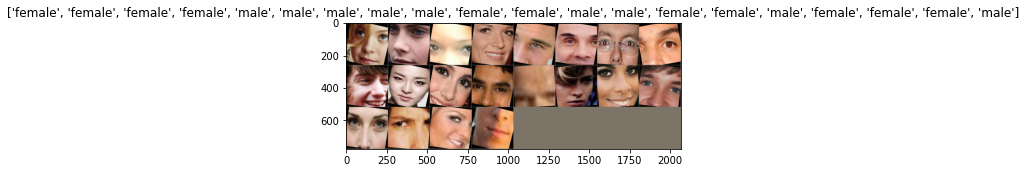

In [25]:
# Возьмем картинки из train и отобразим их
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Настройка модели
Загрузим предварительно обученную модель ResNet50.

In [26]:
resnet_mod = models.resnet50(pretrained=True)

# сбросим последний fully_connected слой
num_ftrs = resnet_mod.fc.in_features
resnet_mod.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [27]:
resnet_mod = resnet_mod.to(device)
# Используем функцию ошибки – кросс-энтропия
criterion = nn.CrossEntropyLoss()

# Оптимизация - стохастический-градиентный спуск
# learning_rate = 0.001
# momentum = 0.9
optimizer_ft = optim.SGD(resnet_mod.parameters(), lr=0.001, momentum=0.9)

# экспоненциальное затухание каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Функция тренировки модели нейронной сети

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # установка начальных значений лучшей модели
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('=' * 40)

        # Для каждой эпохи пробегаемся по train, valid
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0

            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                labels -= 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Установка градиентов в ноль перед обратным распространением,
                # потом что накапливаются градиенты
                optimizer.zero_grad()

                # Для train запоминаем loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Сохраняем функцию потерь
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # Сохраняем модель, если ее accuracy больше
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Загружаем и возвращаем лучшую модель
    model.load_state_dict(best_model_wts)
    return model

In [29]:
# запускаем тренировку модели resnet_mod на новых данных
# с кросс-энтропией, SGD, с эксп.затух и с количеством эпох num_epochs = 12
base_model = train_model(resnet_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)

Epoch 1/12
Iterating through data...
train Loss: 0.4265 Acc: 0.7913
Iterating through data...
valid Loss: 0.1459 Acc: 0.9433

Epoch 2/12
Iterating through data...
train Loss: 0.2728 Acc: 0.8793
Iterating through data...
valid Loss: 0.1273 Acc: 0.9527

Epoch 3/12
Iterating through data...
train Loss: 0.2397 Acc: 0.9001
Iterating through data...
valid Loss: 0.1256 Acc: 0.9480

Epoch 4/12
Iterating through data...
train Loss: 0.2150 Acc: 0.9089
Iterating through data...
valid Loss: 0.0939 Acc: 0.9633

Epoch 5/12
Iterating through data...
train Loss: 0.1802 Acc: 0.9237
Iterating through data...
valid Loss: 0.1282 Acc: 0.9527

Epoch 6/12
Iterating through data...
train Loss: 0.1903 Acc: 0.9180
Iterating through data...
valid Loss: 0.0996 Acc: 0.9593

Epoch 7/12
Iterating through data...
train Loss: 0.1573 Acc: 0.9337
Iterating through data...
valid Loss: 0.0842 Acc: 0.9667

Epoch 8/12
Iterating through data...
train Loss: 0.1542 Acc: 0.9360
Iterating through data...
valid Loss: 0.0854 Acc: 

Сохранение лучшей модели на гугл диск

In [31]:
model_save_name = 'BestModelMain.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(base_model, path)

Попробуем поставить оптимизатор Adam

In [44]:
optimizer_ft_2 = optim.Adam(resnet_mod.parameters())

In [45]:
# запускаем тренировку модели resnet_mod на num_epochs = 15
base_model = train_model(resnet_mod, criterion, optimizer_ft_2, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
Iterating through data...
train Loss: 0.5626 Acc: 0.7160
Iterating through data...
valid Loss: 0.3233 Acc: 0.8527

Epoch 2/15
Iterating through data...
train Loss: 0.4116 Acc: 0.8111
Iterating through data...
valid Loss: 0.2245 Acc: 0.9127

Epoch 3/15
Iterating through data...
train Loss: 0.3848 Acc: 0.8256
Iterating through data...
valid Loss: 0.2288 Acc: 0.8967

Epoch 4/15
Iterating through data...
train Loss: 0.3448 Acc: 0.8441
Iterating through data...
valid Loss: 0.2384 Acc: 0.9080

Epoch 5/15
Iterating through data...
train Loss: 0.3314 Acc: 0.8513
Iterating through data...
valid Loss: 0.2491 Acc: 0.9020

Epoch 6/15
Iterating through data...
train Loss: 0.3201 Acc: 0.8600
Iterating through data...
valid Loss: 0.2702 Acc: 0.8727

Epoch 7/15
Iterating through data...
train Loss: 0.3106 Acc: 0.8609
Iterating through data...
valid Loss: 0.1492 Acc: 0.9327

Epoch 8/15
Iterating through data...
train Loss: 0.2954 Acc: 0.8674
Iterating through data...
valid Loss: 0.2333 Acc: 

Accuracy чуть ниже, чем при SGD.
Попробуем метод AdamGrad

In [46]:
optimizer_ft_3 = optim.Adagrad(resnet_mod.parameters(), lr = 0.001)

In [47]:
# запускаем тренировку модели resnet_mod на num_epochs = 15
base_model = train_model(resnet_mod, criterion, optimizer_ft_3, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
Iterating through data...
train Loss: 0.2299 Acc: 0.9040
Iterating through data...
valid Loss: 0.1120 Acc: 0.9553

Epoch 2/15
Iterating through data...
train Loss: 0.2205 Acc: 0.9034
Iterating through data...
valid Loss: 0.1137 Acc: 0.9520

Epoch 3/15
Iterating through data...
train Loss: 0.2059 Acc: 0.9116
Iterating through data...
valid Loss: 0.1075 Acc: 0.9593

Epoch 4/15
Iterating through data...
train Loss: 0.1973 Acc: 0.9180
Iterating through data...
valid Loss: 0.1056 Acc: 0.9593

Epoch 5/15
Iterating through data...
train Loss: 0.2074 Acc: 0.9094
Iterating through data...
valid Loss: 0.1050 Acc: 0.9573

Epoch 6/15
Iterating through data...
train Loss: 0.1971 Acc: 0.9173
Iterating through data...
valid Loss: 0.1062 Acc: 0.9560

Epoch 7/15
Iterating through data...
train Loss: 0.1965 Acc: 0.9160
Iterating through data...
valid Loss: 0.1102 Acc: 0.9533

Epoch 8/15
Iterating through data...
train Loss: 0.1943 Acc: 0.9189
Iterating through data...
valid Loss: 0.1066 Acc: 

In [48]:
model_save_name = 'BestModelMain_2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(base_model, path)

Итог: лучший результат показала первая модель с SGD и показателем accuracy on validation => 0.969333

Функция predict для test данных. Проверка работоспособности.
P.S.Вынес в отдельный файл process.py

In [49]:
import json
from PIL import Image

def predict(directory):
    result = {}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            im = Image.open(image_path)
            image_tensor = main_transforms['test'](im).float()
            image_tensor = image_tensor.unsqueeze_(0)
            input = Variable(image_tensor)
            input = input.to(device)
            output = base_model(input)
            index = output.data.cpu().numpy().argmax()
            result[image_path] = class_names[index + 1]
    return json.dumps(result)

In [ ]:
predict('/content/internship_data/test/')

In [ ]:
load_model = torch.load('/content/internship_data/BestModelMain.pt')
load_model.eval()

Predict labels для всех изображений в папке directory. Перенес в process.py

In [4]:
import sys
import json
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(directory):
    result = {}
    class_names = ['female', 'male']
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            im = Image.open(image_path)
            image_tensor = main_transforms['test'](im).float()
            image_tensor = image_tensor.unsqueeze_(0)
            input = Variable(image_tensor)
            input = input.to(device)
            output = load_model(input)
            index = output.data.cpu().numpy().argmax()
            result[image_path] = class_names[index]
    with open("process_results.json", 'w') as f:
        f.write(json.dumps(result))

if __name__ == "__main__":
    predict('/content/internship_data/test')
